In [ ]:
# # uncomment and run to install any required modules from requirements.txt
# import sys
# !{sys.executable} -m pip install -r requirements.txt

# NP-FAERS model train and test
This notebook uses the natural products annotation corpus to train and test a Siamese recurrent network that maps strings in FAERS to standardized natural product names.

# Load data

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output
import re

## Preprocess Data

1. Remove digits and punctuation
2. Upper case
3. Mutating strings (not in this version)

In [2]:
#if starting from preprocess, load the drugs directly
df = pd.read_csv('data/NP_FAERS_mapped_20220215.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5358 entries, 0 to 5357
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   FAERS_drug_match  5358 non-null   object
 1   lookup_value      5358 non-null   object
dtypes: object(2)
memory usage: 83.8+ KB


In [3]:
df.loc[df['FAERS_drug_match'].isna()]

,FAERS_drug_match,lookup_value


In [4]:
#make all casing upper
df['FAERS_drug_match'] = df['FAERS_drug_match'].str.upper()
df['lookup_value'] = df['lookup_value'].str.upper()

In [5]:
df.head()

,FAERS_drug_match,lookup_value
0,"ADRENAL HEALTH (BRAND) = (SIBERIAN RHODIOLA, R...",ASHWAGANDA
1,ASHWAGANDHA,ASHWAGANDA
2,"ASHWAGANDHA,",ASHWAGANDA
3,ASHWAGANDHA /01660201/,ASHWAGANDA
4,ASHWAGANDHA /01660201/,ASHWAGANDA


In [6]:
df.lookup_value.unique().shape

(126,)

# RNN character-based encoder - Siamese Network

## Experiments
1. Unique natural product strings 
2. Unique natural product string and exact matches from lookup values
3. Unique natural product strings with indications
4. Mutations?

### Set up positive pairs and negative pairs  
  - positive pairs coded 'yes' in annotation corpus
  - negative pairs coded 'no' in annotation corpus

In [2]:
import tensorflow as tf
import string
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

## Functions to process data

In [3]:
# how i add noise 
# string w 
# proportion of noise added 
# uniform random from [0,1]
# if <1/3 edit one position with new random character, else if <2/3 delete one position, else add one random character 
def add_noise(w, percent):
  ''' edit, del, add'''
  positions = random.choices(range(len(w)), k=int(percent*len(w)))
  for p in positions:
    r = random.random()
    if r <= 0.3333: # edit
      w = w[:p] + random.choice(string.ascii_uppercase) + w[p+1:]
    elif r<= 0.6667: # delete
      w = w[:p] + w[p+1:]
    elif r<=1: # add
      w = w[:p] + random.choice(string.ascii_uppercase) + w[p:]
  return w

def clean(text):
    #remove all non-ascii, special characters and keep alphabets and space only. Can also use isalpha()
    #convert to uppercase
    #remove extra spaces
    regex = re.compile('[^a-zA-Z ]')
    r = regex.sub('', text)
    result = re.sub(' +', ' ', r)
    result = result.strip()
    return result.upper()

In [4]:
def clean_dataset(data):
  x = []
  y = []
  for i in range(data.shape[0]):
    w = clean(data.FAERS_drug_match.iloc[i])
    v = clean(data.lookup_value.iloc[i])
    x.append(w)
    y.append(v)
  return x,y

def encode_dataset(x,y):
  encode_dict = {l:i+1 for i,l in enumerate(string.ascii_uppercase + " ")}
  Xtrain = [[encode_dict[m] for m in n] for n in x]
  Ytrain = [[encode_dict[m] for m in n] for n in y]
  return Xtrain, Ytrain

def clean_encode_padding(q, maxlen):
  q = clean(q)
  encode_dict = {l:i+1 for i,l in enumerate(string.ascii_uppercase + " ")}
  return tf.keras.preprocessing.sequence.pad_sequences(
    [encode_dict[m] for m in q] , padding="post", maxlen=maxlen)

def padding_dataset(X,Y,maxlen):
  padded_y = tf.keras.preprocessing.sequence.pad_sequences(
    Y, padding="post", maxlen=maxlen)
  padded_x = tf.keras.preprocessing.sequence.pad_sequences(
      X, padding="post", maxlen=maxlen)
  return padded_x, padded_y


In [5]:
def model_predict(model, query, drugnames,maxlen):
  predictions = model.predict([clean_encode_padding(query,maxlen), drugnames])
  return [p[0] for p in predictions]

In [6]:
def cosine_distance(vects):
    x, y = vects
    return 1-tf.reduce_sum(tf.multiply(x,y),axis=1, keepdims=True)/(tf.norm(x,axis=1,keepdims=True)*tf.norm(y,axis=1,keepdims=True))

def loss(margin=1):
    def contrastive_loss(y_true, y_pred):
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [7]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


## Experiment 1

In [13]:
train, test = train_test_split(df, test_size=0.20, random_state=42)

In [14]:
train.shape

(4286, 2)

In [15]:
test.shape

(1072, 2)

In [16]:
#padding length = maxlen
maxlen = 60

In [17]:
xtest, ytest = clean_dataset(test)
Xtest, Ytest = encode_dataset(xtest,ytest)
padded_xTest, padded_yTest = padding_dataset(Xtest,Ytest,maxlen)

In [18]:
padded_xTest.shape

(1072, 60)

In [19]:
#without noise (Experiment 1)
x, y = clean_dataset(train)

In [20]:
len(y)

4286

In [21]:
encode_dict = {l:i+1 for i,l in enumerate(string.ascii_uppercase + " ")}

In [22]:
Xtrain = [[encode_dict[m] for m in n] for n in x]
Ytrain = [[encode_dict[m] for m in n] for n in y]

In [23]:
print(len(Xtrain))
print(len(Ytrain))
np.unique(Ytrain).shape

4286
4286


/home/sanya/.conda/envs/faers-embed/lib/python3.8/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


(125,)

In [24]:
padded_y = tf.keras.preprocessing.sequence.pad_sequences(
    Ytrain, padding="post", maxlen=maxlen
)
padded_x = tf.keras.preprocessing.sequence.pad_sequences(
    Xtrain, padding="post", maxlen=maxlen
)

print(padded_y)

[[19  5 18 ...  0  0  0]
 [15 16  8 ...  0  0  0]
 [ 3  9 14 ...  0  0  0]
 ...
 [ 1 12 12 ...  0  0  0]
 [ 1 12 12 ...  0  0  0]
 [ 8  5 13 ...  0  0  0]]


In [25]:
len(encode_dict)

27

In [26]:
dUnique_df = pd.DataFrame(columns = ['dUnique_label','dUnique_seq', 'dUnique_seq_padded'])
dUnique_df['dUnique_label'] = np.unique(y)
dUnique_df.head()

,dUnique_label,dUnique_seq,dUnique_seq_padded
0,ACTAEA RACEMOSA,NaN,NaN
1,AESCULUS HIPPOCASTANUM,NaN,NaN
2,ALLIUM SATIVUM,NaN,NaN
3,ALOE VERA,NaN,NaN
4,ANGELICA SINENSIS,NaN,NaN


In [27]:
dUnique_seq_list = [[encode_dict[m] for m in n] for n in dUnique_df['dUnique_label'].tolist()]
len(dUnique_seq_list)

125

In [28]:
for i in range(len(dUnique_df.index)):
    dUnique_df.at[i, 'dUnique_seq'] = np.array(dUnique_seq_list[i])
dUnique_df.head()

,dUnique_label,dUnique_seq,dUnique_seq_padded
0,ACTAEA RACEMOSA,"[1, 3, 20, 1, 5, 1, 27, 18, 1, 3, 5, 13, 15, 1...",NaN
1,AESCULUS HIPPOCASTANUM,"[1, 5, 19, 3, 21, 12, 21, 19, 27, 8, 9, 16, 16...",NaN
2,ALLIUM SATIVUM,"[1, 12, 12, 9, 21, 13, 27, 19, 1, 20, 9, 22, 2...",NaN
3,ALOE VERA,"[1, 12, 15, 5, 27, 22, 5, 18, 1]",NaN
4,ANGELICA SINENSIS,"[1, 14, 7, 5, 12, 9, 3, 1, 27, 19, 9, 14, 5, 1...",NaN


In [29]:
#setup negative pairs
dfneg = pd.read_csv('data/NP_FAERS_negative_pairs_20220215.csv')
dfneg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9242 entries, 0 to 9241
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   FAERS_drug_match  9242 non-null   object
 1   lookup_value      9242 non-null   object
dtypes: object(2)
memory usage: 144.5+ KB


In [30]:
#encode negative pairs and add padding
xneg, yneg = clean_dataset(dfneg)
Xneg, Yneg = encode_dataset(xneg,yneg)
padded_xneg, padded_yneg = padding_dataset(Xneg,Yneg,maxlen)

In [31]:
x1TrainRNN = []
x2TrainRNN = []
yTrainRNN = []
for i in range(len(padded_x)):
    yTrainRNN.append(1)
    x1TrainRNN.append(padded_x[i])
    x2TrainRNN.append(padded_y[i])

print(len(x1TrainRNN), len(x2TrainRNN), len(yTrainRNN))    

4286 4286 4286


In [32]:
##for each class get positive and negative pairs
for j in range(len(padded_xneg)):
    yTrainRNN.append(0)
    x1TrainRNN.append(padded_xneg[j])
    x2TrainRNN.append(padded_yneg[j])
print(len(x1TrainRNN), len(x2TrainRNN), len(yTrainRNN))

13528 13528 13528


In [33]:
dUnique = tf.keras.preprocessing.sequence.pad_sequences(
    list(dUnique_df['dUnique_seq']), padding="post", maxlen=60)
for i in range(len(dUnique_df.index)):
    dUnique_df.at[i, 'dUnique_seq_padded'] = dUnique[i]
dUnique_df.head()

,dUnique_label,dUnique_seq,dUnique_seq_padded
0,ACTAEA RACEMOSA,"[1, 3, 20, 1, 5, 1, 27, 18, 1, 3, 5, 13, 15, 1...","[1, 3, 20, 1, 5, 1, 27, 18, 1, 3, 5, 13, 15, 1..."
1,AESCULUS HIPPOCASTANUM,"[1, 5, 19, 3, 21, 12, 21, 19, 27, 8, 9, 16, 16...","[1, 5, 19, 3, 21, 12, 21, 19, 27, 8, 9, 16, 16..."
2,ALLIUM SATIVUM,"[1, 12, 12, 9, 21, 13, 27, 19, 1, 20, 9, 22, 2...","[1, 12, 12, 9, 21, 13, 27, 19, 1, 20, 9, 22, 2..."
3,ALOE VERA,"[1, 12, 15, 5, 27, 22, 5, 18, 1]","[1, 12, 15, 5, 27, 22, 5, 18, 1, 0, 0, 0, 0, 0..."
4,ANGELICA SINENSIS,"[1, 14, 7, 5, 12, 9, 3, 1, 27, 19, 9, 14, 5, 1...","[1, 14, 7, 5, 12, 9, 3, 1, 27, 19, 9, 14, 5, 1..."


In [34]:
x1TrainRnnS, x2TrainRnnS, yTrainRnnS = shuffle(x1TrainRNN, x2TrainRNN, yTrainRNN, random_state=42)

### build model and train

In [35]:
input = tf.keras.layers.Input(maxlen)
input_1 = tf.keras.layers.Input(maxlen)
input_2 = tf.keras.layers.Input(maxlen)
embedding = tf.keras.layers.Embedding(input_dim=28, output_dim=64, mask_zero=True)
x = embedding(input)

print(x.shape)
x = tf.keras.layers.GRU(128)(x)
x = tf.keras.layers.Dense(64, activation="tanh")(x)
x = tf.keras.layers.Dense(32, activation="tanh")(x)
embedding_network = tf.keras.Model(input, x)

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = tf.keras.layers.Lambda(cosine_distance)([tower_1, tower_2])
output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(merge_layer)
siamese = tf.keras.Model(inputs=[input_1, input_2], outputs=output_layer)

2022-02-16 14:06:55.046937: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-16 14:06:56.000957: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9648 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:af:00.0, compute capability: 7.5


(None, 60, 64)


In [36]:
siamese.compile(loss=loss(margin=1), optimizer='RMSprop', metrics=["accuracy"])

In [37]:
history_rnn = siamese.fit([np.array(x1TrainRnnS), np.array(x2TrainRnnS)],np.array(yTrainRnnS, dtype=np.float32), epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100


2022-02-16 14:07:24.786617: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8302


339/339 [==============================] - 23s 30ms/step - loss: 0.1962 - accuracy: 0.6806 - val_loss: 0.1742 - val_accuracy: 0.6936
Epoch 2/100
339/339 [==============================] - 6s 17ms/step - loss: 0.1550 - accuracy: 0.6806 - val_loss: 0.1411 - val_accuracy: 0.6936
Epoch 3/100
339/339 [==============================] - 6s 18ms/step - loss: 0.1341 - accuracy: 0.8303 - val_loss: 0.1273 - val_accuracy: 0.8492
Epoch 4/100
339/339 [==============================] - 6s 18ms/step - loss: 0.1186 - accuracy: 0.8719 - val_loss: 0.1155 - val_accuracy: 0.8688
Epoch 5/100
339/339 [==============================] - 6s 17ms/step - loss: 0.1053 - accuracy: 0.8846 - val_loss: 0.1014 - val_accuracy: 0.8792
Epoch 6/100
339/339 [==============================] - 6s 17ms/step - loss: 0.0938 - accuracy: 0.8954 - val_loss: 0.0979 - val_accuracy: 0.8891
Epoch 7/100
339/339 [==============================] - 6s 17ms/step - loss: 0.0873 - accuracy: 0.9015 - val_loss: 0.0897 - val_accuracy: 0.8965
Epo

In [38]:
siamese.save('models/NP_siamese_exp1_20220216.h5')
siamese.save('models/NP_siamese_exp1_20220216')

2022-02-16 14:17:57.286561: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/NP_siamese_exp1_20220216/assets


INFO:tensorflow:Assets written to: models/NP_siamese_exp1_20220216/assets


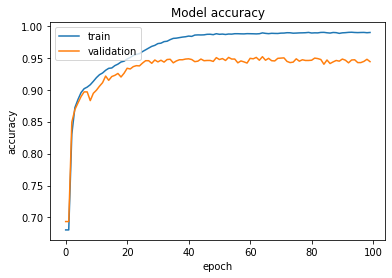

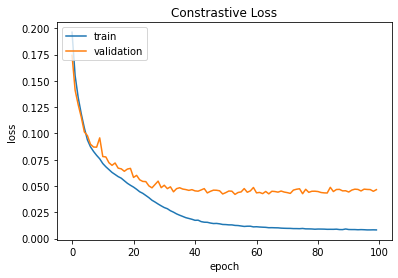

In [39]:
# Plot the accuracy
plt_metric(history=history_rnn.history, metric="accuracy", title="Model accuracy")

# Plot the constrastive loss
plt_metric(history=history_rnn.history, metric="loss", title="Constrastive Loss")

### Load model, get predictions and evaluate siamese network

In [34]:
def contrastive_loss(y_true, y_pred):
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
    return tf.math.reduce_mean(
        (1 - y_true) * square_pred + (y_true) * margin_square
    )

In [35]:
#siamese_loaded = tf.keras.models.load_model('models/drug_siamese_exp1_20220201.h5')
siamese_model = tf.keras.models.load_model('models/drug_siamese_exp1_20220201.h5', custom_objects={'contrastive_loss': contrastive_loss})

2022-02-10 12:16:10.003049: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-10 12:16:10.980701: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 164 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:af:00.0, compute capability: 7.5


In [36]:
siamese_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 model (Functional)             (None, 32)           86624       ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['model[0][0]',            

In [54]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1072 entries, 4003 to 1295
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   FAERS_drug_match  1072 non-null   object
 1   lookup_value      1072 non-null   object
dtypes: object(2)
memory usage: 57.4+ KB


In [40]:
test_eval = pd.DataFrame(columns = ['FAERS_drug_match', 'lookup_value', 'rank1_drug', 'rank2_drug', 'rank3_drug', 'rank4_drug', 'rank5_drug', 'lookup_rank'])

In [41]:
test_res = test.reset_index()
test_res.head()

,index,FAERS_drug_match,lookup_value
0,4003,ST. JOHN'S WORT ^HERRON^ (HYPERICUM PERFORATUM),HYPERICUM PERFORATUM
1,1729,CORDYCEPS,CORDYCEPS
2,401,FLAXSEEDS OIL,FLAX SEED
3,1242,EXTRACT OF SERENOA REPENS (PERMIXON),SCRUB-PALMETTO
4,3406,GUARANA (GUARANA),PAULLINIA CUPANA


In [42]:
#find ranks 1, 2 and 3 (can go upto any number n) from the predicted similarities for the test data
for i in range(padded_xTest.shape[0]):
    predicts = siamese.predict([np.tile(padded_xTest[i,:], (dUnique.shape[0],1)), dUnique])
    argsort = np.argsort(-predicts.flatten())
    test_eval.at[i, 'FAERS_drug_match'] = test_res.at[i, 'FAERS_drug_match']
    test_eval.at[i, 'lookup_value'] = test_res.at[i, 'lookup_value']
    test_eval.at[i, 'rank1_drug'] = dUnique_df.iloc[argsort[0]].dUnique_label
    test_eval.at[i, 'rank2_drug'] = dUnique_df.iloc[argsort[1]].dUnique_label
    test_eval.at[i, 'rank3_drug'] = dUnique_df.iloc[argsort[2]].dUnique_label
    test_eval.at[i, 'rank4_drug'] = dUnique_df.iloc[argsort[3]].dUnique_label
    test_eval.at[i, 'rank5_drug'] = dUnique_df.iloc[argsort[4]].dUnique_label
test_eval.head()

,FAERS_drug_match,lookup_value,rank1_drug,rank2_drug,rank3_drug,rank4_drug,rank5_drug,lookup_rank
0,ST. JOHN'S WORT ^HERRON^ (HYPERICUM PERFORATUM),HYPERICUM PERFORATUM,HYPERICUM PERFORATUM,GRAPEFRUIT,GUARANA,STINGING NETTLE,ELDERBERRY,NaN
1,CORDYCEPS,CORDYCEPS,CORDYCEPS,STEVIA,TULSI,YOHIMBE,SILYBUM MARIANUM,NaN
2,FLAXSEEDS OIL,FLAX SEED,GUARANA,FENUGREEK,GRAPEFRUIT,HYPERICUM PERFORATUM,GREEN TEA,NaN
3,EXTRACT OF SERENOA REPENS (PERMIXON),SCRUB-PALMETTO,HYPERICUM PERFORATUM,GUARANA,STINGING NETTLE,TANACETUM PARTHENIUM,NIU BANG ZI,NaN
4,GUARANA (GUARANA),PAULLINIA CUPANA,PANAX GINSENG,TARAXACUM OFFICINALE,HORSECHESTNUT,FENUGREEK,CRATAEGUS LAEVIGATA,NaN


In [8]:
test_eval = pd.read_csv('evaluation/test_siamese_evaluation_exp1.csv')
test_eval.head()

,FAERS_drug_match,lookup_value,rank1_drug,rank2_drug,rank3_drug,rank4_drug,rank5_drug,lookup_rank
0,ST. JOHN'S WORT ^HERRON^ (HYPERICUM PERFORATUM),HYPERICUM PERFORATUM,HYPERICUM PERFORATUM,GRAPEFRUIT,GUARANA,STINGING NETTLE,ELDERBERRY,1.0
1,CORDYCEPS,CORDYCEPS,CORDYCEPS,STEVIA,TULSI,YOHIMBE,SILYBUM MARIANUM,1.0
2,FLAXSEEDS OIL,FLAX SEED,GUARANA,FENUGREEK,GRAPEFRUIT,HYPERICUM PERFORATUM,GREEN TEA,NaN
3,EXTRACT OF SERENOA REPENS (PERMIXON),SCRUB-PALMETTO,HYPERICUM PERFORATUM,GUARANA,STINGING NETTLE,TANACETUM PARTHENIUM,NIU BANG ZI,NaN
4,GUARANA (GUARANA),PAULLINIA CUPANA,PANAX GINSENG,TARAXACUM OFFICINALE,HORSECHESTNUT,FENUGREEK,CRATAEGUS LAEVIGATA,NaN


In [9]:
for i in range(len(test_eval.index)):
    lookup = test_eval.at[i, 'lookup_value']
    lookup_clean = clean(lookup)
    if lookup_clean == test_eval.at[i, 'rank1_drug']:
        test_eval.at[i, 'lookup_rank'] = 1
    elif lookup_clean == test_eval.at[i, 'rank2_drug']:
        test_eval.at[i, 'lookup_rank'] = 2
    elif lookup_clean == test_eval.at[i, 'rank3_drug']:
        test_eval.at[i, 'lookup_rank'] = 3
    elif lookup_clean == test_eval.at[i, 'rank4_drug']:
        test_eval.at[i, 'lookup_rank'] = 4
    elif lookup_clean == test_eval.at[i, 'rank5_drug']:
        test_eval.at[i, 'lookup_rank'] = 5
test_eval.head()

,FAERS_drug_match,lookup_value,rank1_drug,rank2_drug,rank3_drug,rank4_drug,rank5_drug,lookup_rank
0,ST. JOHN'S WORT ^HERRON^ (HYPERICUM PERFORATUM),HYPERICUM PERFORATUM,HYPERICUM PERFORATUM,GRAPEFRUIT,GUARANA,STINGING NETTLE,ELDERBERRY,1.0
1,CORDYCEPS,CORDYCEPS,CORDYCEPS,STEVIA,TULSI,YOHIMBE,SILYBUM MARIANUM,1.0
2,FLAXSEEDS OIL,FLAX SEED,GUARANA,FENUGREEK,GRAPEFRUIT,HYPERICUM PERFORATUM,GREEN TEA,NaN
3,EXTRACT OF SERENOA REPENS (PERMIXON),SCRUB-PALMETTO,HYPERICUM PERFORATUM,GUARANA,STINGING NETTLE,TANACETUM PARTHENIUM,NIU BANG ZI,NaN
4,GUARANA (GUARANA),PAULLINIA CUPANA,PANAX GINSENG,TARAXACUM OFFICINALE,HORSECHESTNUT,FENUGREEK,CRATAEGUS LAEVIGATA,NaN


In [10]:
test_eval.to_csv("evaluation/test_siamese_evaluation_exp1.csv", index=False)

### Scratch code blocks below

In [ ]:
##add code for precision @k, MAP and nDCG

In [37]:
#in test set, find all NPs and create NP-test
npref = pd.read_csv('data/np_faers_reference_set_202202101209.csv')
npref.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2679 entries, 0 to 2678
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   seq                     2679 non-null   int64  
 1   drug_name_original      2679 non-null   object 
 2   related_common_name     2679 non-null   object 
 3   related_latin_binomial  2679 non-null   object 
 4   lookup_value            2679 non-null   object 
 5   concept_id              1925 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 125.7+ KB


In [50]:
testnp = test.reset_index()
testnp.head()

,index,drug_name_original,lookup_value
0,368981,NITROGLYCERIN PILLS,NITROGLYCERIN
1,20960,VITAMINS/MINERALS D3 B50 COMPLEX,MULTIVITAMIN PREPARATION
2,320735,T. SELOKEN ZOC (METOPROLOL SUCCINATE),METOPROLOL SUCCINATE
3,34002,CEFTUM TABLET,CEFUROXIME AXETIL
4,321068,VALPROATE (TABLETS) VALPROATE SODIUM,VALPROATE SODIUM


In [39]:
testnp_df = pd.merge(testnp, npref, how='inner', on=['drug_name_original'])
testnp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 483 entries, 0 to 482
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   index                   483 non-null    int64  
 1   drug_name_original      483 non-null    object 
 2   lookup_value_x          483 non-null    object 
 3   seq                     483 non-null    int64  
 4   related_common_name     483 non-null    object 
 5   related_latin_binomial  483 non-null    object 
 6   lookup_value_y          483 non-null    object 
 7   concept_id              340 non-null    float64
dtypes: float64(1), int64(2), object(5)
memory usage: 34.0+ KB


In [41]:
testnp_df = testnp_df[['index', 'drug_name_original', 'lookup_value_x']]
testnp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 483 entries, 0 to 482
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   index               483 non-null    int64 
 1   drug_name_original  483 non-null    object
 2   lookup_value_x      483 non-null    object
dtypes: int64(1), object(2)
memory usage: 15.1+ KB


In [43]:
testnp_df = testnp_df.rename(columns={"lookup_value_x": "lookup_value"})

In [44]:
testnp_df.to_csv('evaluation/test_set_np.csv', index=False)

In [45]:
test_np_eval = pd.DataFrame(columns = ['drug_name_original', 'lookup_value', 'rank1_drug', 'rank2_drug', 'rank3_drug', 'lookup_rank'])

In [46]:
testnp_df.head()

,index,drug_name_original,lookup_value
0,106183,CRANBERRY CHEWS,CRANBERRY
1,106466,BARLEY GREEN,BARLEY GRASS
2,107020,CRANBERRY [VACCINIUM MACROCARPON,CRANBERRY
3,322801,GREEN TEA OTC,GREEN TEA
4,106189,FLAX CAPSULES,FLAX SEED


In [51]:
npxtest, npytest = clean_dataset(testnp_df)
npXtest, npYtest = encode_dataset(npxtest,npytest)
nppadded_xTest, nppadded_yTest = padding_dataset(npXtest,npYtest)

In [54]:
#testing model on only NPs in test set
for i in range(len(testnp_df.index)):
    np_index = testnp_df.at[i, 'index']
    predicts = siamese_model.predict([np.tile(nppadded_xTest[i,:], (dUnique.shape[0],1)), dUnique])
    argsort = np.argsort(-predicts.flatten())
    test_np_eval.at[i, 'drug_name_original'] = test.at[np_index, 'drug_name_original']
    test_np_eval.at[i, 'lookup_value'] = test.at[np_index, 'lookup_value']
    test_np_eval.at[i, 'rank1_drug'] = dUnique_df.iloc[argsort[0]].dUnique_label
    test_np_eval.at[i, 'rank2_drug'] = dUnique_df.iloc[argsort[1]].dUnique_label
    test_np_eval.at[i, 'rank3_drug'] = dUnique_df.iloc[argsort[2]].dUnique_label
test_np_eval.head()

2022-02-10 12:39:08.325967: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8302


,drug_name_original,lookup_value,rank1_drug,rank2_drug,rank3_drug,lookup_rank
0,CRANBERRY CHEWS,CRANBERRY,CRANBERRY JUICE,CRANBERRY PREPARATION,CRANBERRY,NaN
1,BARLEY GREEN,BARLEY GRASS,BARLEY GRASS,BARBITAL,BARBEXACLONE,NaN
2,CRANBERRY [VACCINIUM MACROCARPON,CRANBERRY,CANRENOATE POTASSIUM,CRANTEX LA,CRANBERRY EXTRACT,NaN
3,GREEN TEA OTC,GREEN TEA,GREEN TEA EXTRACT,GREEN TEA,GREEN TEA LEAF EXTRACT,NaN
4,FLAX CAPSULES,FLAX SEED,FLURESS,FLUOROURACIL,FLUANXOL,NaN


In [55]:
for i in range(len(test_np_eval.index)):
    lookup = test_np_eval.at[i, 'lookup_value']
    if lookup == test_np_eval.at[i, 'rank1_drug']:
        test_np_eval.at[i, 'lookup_rank'] = 1
    elif lookup == test_np_eval.at[i, 'rank2_drug']:
        test_np_eval.at[i, 'lookup_rank'] = 2
    elif lookup == test_np_eval.at[i, 'rank3_drug']:
        test_np_eval.at[i, 'lookup_rank'] = 3
test_np_eval.head()


,drug_name_original,lookup_value,rank1_drug,rank2_drug,rank3_drug,lookup_rank
0,CRANBERRY CHEWS,CRANBERRY,CRANBERRY JUICE,CRANBERRY PREPARATION,CRANBERRY,3
1,BARLEY GREEN,BARLEY GRASS,BARLEY GRASS,BARBITAL,BARBEXACLONE,1
2,CRANBERRY [VACCINIUM MACROCARPON,CRANBERRY,CANRENOATE POTASSIUM,CRANTEX LA,CRANBERRY EXTRACT,NaN
3,GREEN TEA OTC,GREEN TEA,GREEN TEA EXTRACT,GREEN TEA,GREEN TEA LEAF EXTRACT,2
4,FLAX CAPSULES,FLAX SEED,FLURESS,FLUOROURACIL,FLUANXOL,NaN


In [56]:
test_np_eval.to_csv('evaluation/siamese_eval_NP_exp1.csv', index=False)

# Comparison between methods
- use hit@topK metrics 

In [ ]:
def hit_at_k(predictions):
  
    N = len(predictions)
    hitAt = []
    predictions = np.array(predictions)
    predictions.sort()
    
    for k in range(N):
      atK = (predictions <= k).sum()
      hitAt.append(atK/N)

    return hitAt

In [ ]:
se = hit_at_k(ranksEmbed)
mp = hit_at_k(all_f[0])
nm = hit_at_k(all_f2[0])
sn = hit_at_k(siamese_ranks)

In [ ]:
se10 = [hit_at_k(r) for r in ranks10]
mp10 = [hit_at_k(r) for r in ranks10_mp_0]
nm10 = [hit_at_k(r) for r in ranks10_nm_0]

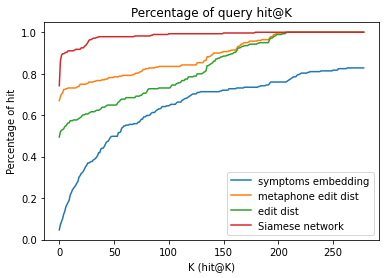

In [ ]:
plt.plot(range(len(se)), se, label="symptoms embedding")
plt.plot(range(len(se)), mp, label="metaphone edit dist")
plt.plot(range(len(se)), nm, label="edit dist")
plt.plot(range(len(se)), sn, label="Siamese network")
plt.legend()
plt.xlabel("K (hit@K)")
plt.ylabel("Percentage of hit")
plt.title("Percentage of query hit@K")
plt.show()

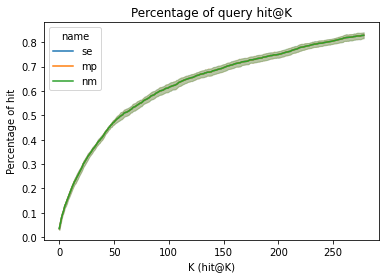

In [ ]:
# I need to repeat this. Last time I use wrong variables. -*- 

dt1 = pd.DataFrame(se10)
dt1 = pd.melt(dt1.reset_index(), id_vars="index")
dt1["name"] = "se"
dt2 = pd.DataFrame(mp10)
dt2 = pd.melt(dt2.reset_index(), id_vars="index")
dt2["name"] ="mp"
dt3 = pd.DataFrame(nm10)
dt3 = pd.melt(dt3.reset_index(), id_vars="index")
dt3["name"] = "nm"
dt =pd.concat([dt1,dt2,dt3])

sns.lineplot( x = "variable", y = "value", hue="name", data=dt.reset_index(drop=True))
plt.xlabel("K (hit@K)")
plt.ylabel("Percentage of hit")
plt.title("Percentage of query hit@K")
plt.show()